# Dog Breed Identification built with Fast.ai's CNN using transfer learning
---
## Description

This project will take on a dog breed identification challenge by [Kaggle](https://www.kaggle.com/competitions/dog-breed-identification). The challenge uses the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/).

You can [download](https://www.kaggle.com/competitions/dog-breed-identification/data) the entire dataset as a `.zip` file (you need a free Kaggle account to be able to download the file).

This project employs the [Fast.ai](https://github.com/fastai/fastai) library to create an image classification model that leverages transfer learning and a convolutional neural network (CNN) to accurately identify different dog breeds.

This project serves as the technical foundation for my bachelor's thesis on dog breed classification. The aim of this project, as well as my thesis, is to evaluate the efficiency and accuracy of my model when compared to similar models trained on the Standford Dogs Dataset.

This notebook additionally explores the concepts of exploratory data analysis (EDA), data augmentation, and image pre-processing among others.

---
## Goals

The goal of an image classification problem is to minimize the loss. Loss refers to the measure of how well a model's predictions match the actual classes/labels of the training data. A lower loss value indicates that the model is more accurate at making predictions.

Striving for a high level of accuracy is also key. Accuracy is measured by how well the trained model can correctly predict the classes of unseen new images.

---
## Structure

This is a broad overview of the main table of contents for this notebook:
1.   Installs, Imports & Settings
2.   Load the dataset
3.   EDA
4.   Training
5.   Dataloader
6.   Logging
7.   Post-Training Analysis
8.   Predictions
9.   Exports
10.  Clean-up
---
## Technical Specifications

Begin by downloading the repo [GitHub](https://github.com/krullmizter/dog-breed-identification-fastai). If you don't have the dataset `.zip` file, download it from [Kaggle](https://www.kaggle.com/competitions/dog-breed-identification/data) (A free Kaggle account is needed).

### Local Development

If you run this notebook locally, I recommend running it with administrative privileges.

This project was coded locally in a virtual environment using [Anaconda notebooks](https://anaconda.org/). When working with Anaconda I recommend creating a separate development environment before starting. You can use my base env. file `environment.yml` from the GitHub repo.

### Google Colab

If you want an easy way to run this notebook, use cloud-hosted GPUs, and have an easy time with dependencies and packages, then use [Google Colab](https://colab.research.google.com/). To get started upload the `main.ipynb` to Colab. Then upload the dataset `.zip` file to your Google Drive. Lastly, change `colab = True` in the settings cell.

### Training Stats

When working with this notebook, a directory called `training` will be created. It will hold a `.json` file with the stats of the model's training since its first successful training run. This way, one can view the past training stats to help with tweaking the model further. The directory will also hold the exported trained model as a `.pkl` file.

### Development

My training was computed locally on an RTX-3070 GPU.

Required installations and which versions I used (specified versions are not required):
* Python (3.10.9)
* PyTorch (2.0.0)
    * PyTorch CUDA (11.7)
* Fast.ai (2.7.12)

If you wish to use exactly my dependencies, and Python packages then download and use the `environment.yml` and `requirements.txt` respectively from the repo [GitHub](https://github.com/krullmizter/dog-breed-identification-fastai).

If your conda installation can't find a certain package to download, then a tip is to use the dependency name, and the `-c` flag to specify from what channel you wish to download the dependency from:

`conda install fastai pytorch pytorch-cuda -c fastai -c pytorch -c nvidia`

---
## TODO
* Automatic download of the Stanford dataset `.zip` file from Kaggle if it's not downloaded.
* Better: `item_tfms` and `batch_tfms`.
* Single or multi-item detection.
* View bounding boxes.
* Hover effect over the second scatter plot.
* Clean up (remove `.zip` file).
* Link to thesis when done.
* Publish code, choose a license.
---
Created by: Samuel Granvik [GitHub](https://github.com/krullmizter/) | [LinkedIn](https://www.linkedin.com/in/samuel-granvik-93977013a/)

## Installs & Imports

In [73]:
try:
    import warnings
    warnings.filterwarnings('ignore', category=UserWarning) 

    import re # RegEx
    import os # Let's us interact with the underlying OS
    import json
    import random # Random numbers
    import requests # Handles HTTP requests
    import numpy as np # Math functions
    import pandas as pd # Data analysis and manipulation
    from bs4 import BeautifulSoup # Parse HTML
    from datetime import datetime # Let's us use date and time
    from matplotlib import pyplot as plt # Visualisations

    from fastai import __version__
    from fastai.vision.all import * # Computer vision
    from fastai.metrics import error_rate, accuracy # Additional metrics
    
    print('Imports complete.\n')

except ImportError as e:
    print(f'Error importing one or more libraries: {e}')

if torch.cuda.is_available():
    print('Using versions: \nFastai v.', __version__, '\nPyTorch v.', torch.__version__, '\nCUDA v.', torch.version.cuda)
    print(f'\nUsing GPU: {torch.cuda.get_device_name(0)}.')
else:
    print('Please install PyTorch CUDA, with GPU utilized the model will be faster.')

Imports complete.

Using versions: 
Fastai v. 2.7.12 
PyTorch v. 2.0.0+cu118 
CUDA v. 11.8

Using GPU: NVIDIA A100-SXM4-40GB.


## Settings & Paths

In [2]:
# Settings, variables & paths

'''
If export_model is set to true, the code will export the trained model (.pkl) file to the trained directory
If show_plots is set to true, then a plot of the images widths and heights will be displayed
If colab is set to true it means that you are working from a Google Colab env. please download the dataset .zip file to your Google Drive (https://www.kaggle.com/competitions/dog-breed-identification/data)
Log set to true will output training stats to the stats (.json) file

Default settings booleans: False, True, False, True, False
'''

export_model, show_plots, colab, log = False, False, False, True

if colab: print('You are working from a Google Colab right? If not, change the variable colab in the settings cell.')

# Automatic reloading, and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Paths 

# Directories
base_dir    = os.getcwd()
dataset_dir = os.path.join(base_dir, 'stanford-dogs-dataset')
train_dir   = os.path.join(dataset_dir, 'train')
test_dir    = os.path.join(dataset_dir, 'test')
trained_dir = os.path.join(base_dir, 'trained')

# Google Drive dir.
drive_dir = '/content/drive'

# Files
dataset_zip   = os.path.join(base_dir, 'stanford-dogs-dataset.zip')
trained_stats = os.path.join(trained_dir, 'trained_model_stats.json')
trained_model = os.path.join(trained_dir, 'trained_model.pkl')
sub_csv       = os.path.join(trained_dir, 'submission.csv')

You are working from a Google Colab right? If not, change the variable colab in the settings cell.


## Load Dataset

In [3]:
# Unzip the dataset .zip file if the dataset dir. doesn't exist, either from Google Drive (if colab = True), or locally
if not os.path.exists(dataset_dir):
  if colab:
    print('Unzipping the dataset from Google Drive.')
    
    from google.colab import drive 
    drive.mount(drive_dir)
    
    # Unzip the dataset quietly, and move the content to the newly created dataset directory
    !unzip -qq /content/drive/MyDrive/dog-breed-identification.zip -d {dataset_dir} 
    print('Unzipped the dataset.')
  else:
    try:
      print(f'Unzipping: {dataset_zip}')
        
      with zipfile.ZipFile(dataset_zip, 'r') as z:
        z.extractall(dataset_dir)
      z.close()
        
      print('Unzipped the dataset.')
    except Exception as e:
      print(f'An error occurred while unzipping the {dataset_zip}: {e}')
else:
  print(f'{dataset_dir} already exists.')

Unzipping the dataset from Google Drive.
Mounted at /content/drive
Unzipped the dataset.


## EDA - Exploratory Data Analysis

### EDA - Labels

In [4]:
labels_df = pd.read_csv(os.path.join(dataset_dir, 'labels.csv'))

print(f'Some basic info of the labels.\n')
display(labels_df.info())

print('Shows us the labels.csv file, containing IDs for images, and their corresponding breed.')
labels_df.head()

Some basic info of the labels.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


None

Shows us the labels.csv file, containing IDs for images, and their corresponding breed.


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
print('The three breeds/classes with the most, and least amount of images.')

amount_breed = labels_df.pivot_table(index='breed', aggfunc=len).rename(columns={'id': 'amount'})

largest  = amount_breed.nlargest(3, 'amount')
smallest = amount_breed.nsmallest(3, 'amount')

pd.concat([largest, smallest])

The three breeds/classes with the most, and least amount of images.


,amount
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
briard,66
eskimo_dog,66
brabancon_griffon,67


### EDA - Images

In [6]:
if show_plots:
    # Analyze training images widths and heights
    all_widths, all_heights, min_res_list, max_res_list = [], [], [], []

    min_res_img, max_res_img = '', ''

    min_pxs = float('inf')
    max_pxs = float('-inf')
    
    # Loop over all images in the training dir. 
    for f in os.listdir(train_dir):
        img_path = os.path.join(train_dir, f)
        
        # Add the resolution of each image to separate arrays of widths and heights
        with Image.open(img_path) as img:
            w, h = img.size
        
            all_widths.append(w)
            all_heights.append(h)
        
            pxs = w * h
            
            # Check which image has the smallest and largest resolution
            if pxs < min_pxs:
                min_pxs = pxs
                min_res_list = [w, h]
                min_res_name = f
            elif pxs > max_pxs:
                max_pxs = pxs
                max_res_list = [w, h]
                max_res_name = f
        img.close()
            
    print(f'Resolution Statistics:')
    print(f'Average: { int(sum(all_widths) / len(all_widths)) }x{ int(sum(all_heights) / len(all_heights)) }px')
    print(f'Smallest: {min_res_list[0]}x{min_res_list[1]}px ({min_res_name})')
    print(f'Largest: {max_res_list[0]}x{max_res_list[1]}px ({max_res_name})')

    # Plot the distrubutions of the training image's width and height on two scatter plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    min_widths  = min(all_widths)+1
    max_widths  = max(all_widths)+1
    min_heights = min(all_heights)+1
    max_heights = max(all_heights)+1

    # Shows the entire training dataset distrubution
    ax1.scatter(all_widths, all_heights, alpha=0.25, s=3, color='green')
    ax1.set_title('Distribution of the training images by resolution.')
    ax1.set_xlabel('Width (px)')
    ax1.set_xticks(np.arange(0, max_widths, 200))
    ax1.set_ylabel('Height (px)')
    ax1.set_yticks(np.arange(0, max_heights, 200))

    # Shows a plot which is zoomed in on the more concentrated values
    xmin, xmax, ymin, ymax = min_res_list[0], 750, min_res_list[1], 750
    ax2.scatter(all_widths, all_heights, alpha=0.25, s=25, color='green')
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(ymin, ymax)
    ax2.set_title('Zoomed-in view of the distribution of the training images by resolution.')
    ax2.set_xlabel('Width (px)')
    ax2.set_xticks(np.arange(xmin, xmax+1, 25))
    ax2.set_ylabel('Height (px)')
    ax2.set_yticks(np.arange(ymin, ymax+1, 50))

    plt.subplots_adjust(hspace=.25)
    plt.show()
else:
    print('If you wish to show the plots, change the show_plots variable in the settings cell.')

If you wish to show the plots, change the show_plots variable in the settings cell.


## Training

### Hyperparameters & Data Augmentation

In [56]:
arch = resnet101 # Pre-trained model we train upon
ep = 1 # One epoch refers to the entire training dataset being proceced one time in the neural network
bs = 64 # Amount of images to feed in one batch to the neural network during one training iteration
sz = 224 # The target size of each image that gets fed into the network

# A set amount of transformations applied to each image in the dataset to standardize the input images
item_tfms = [Resize(sz)]

# Transformations such as random noise or pixel value changes applied to a batch of images in the dataset
batch_tfms = [
    *aug_transforms(size=sz, max_warp=0), 
    Normalize.from_stats(*imagenet_stats)
]

print(f'Training will use: {ep} epochs, with a batch size of: {bs}, and the target size of each input image is: {sz}px.')

Training will use: 1 epochs, with a batch size of: 64, and the target size of each input image is: 224px.


### Dataloader

In [8]:
# We use a dataloader to load our dataset, and also augment and pre-process the data
dls = ImageDataLoaders.from_csv(
    path=dataset_dir,
    folder='train',
    test='test',
    suff='.jpg',
    size=sz,
    bs=bs,
    item_tfms=item_tfms, 
    batch_tfms=batch_tfms,
    max_split_size_mb=512,
    device='cuda'
)

train_len = len(dls.train_ds)
val_len   = len(dls.valid_ds)
test_len  = len(os.listdir(test_dir))

print(f'Amount of images in each dataset\nTotal: { (train_len + val_len) + test_len }.\n')
print(f'Train: {train_len}\nValidation: {val_len} ({val_len/train_len:.0%} of train) \nTest: {test_len}')

Amount of images in each dataset
Total: 20579.

Train: 8178
Validation: 2044 (25% of train) 
Test: 10357


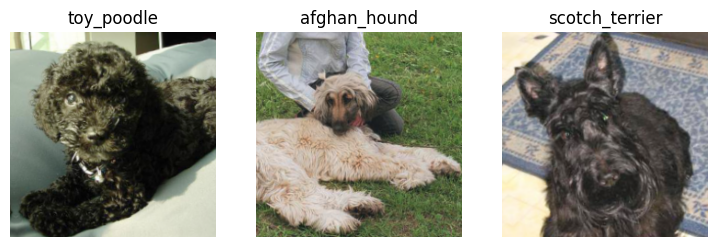

In [9]:
# Show some random training images and their corresonding labels
dls.show_batch(max_n=3)

### Learner

In [10]:
'''
Here we create main training object a learner object to aid in setting up, pre-process, running the training loop
The learner combines the previously created dls, and our chosen pre-trained network, along with training metrics
'''

learner = cnn_learner(
    dls,
    arch,
    metrics=[error_rate, accuracy]
)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 265MB/s]


In [11]:
# This lets us view our models architecture, layers and our defined hyperparameters
learner.summary()

Sequential (Input shape: 128 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 64 x 112 x 11 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 56 x 56  
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     128 x 256 x 56 x 56 
Conv2d                                    16384      False     
BatchNorm2d                       

### Learning Rate

Suggested learning rate: 0.0003981071640737355, and its exponential notation: 3.98e-04


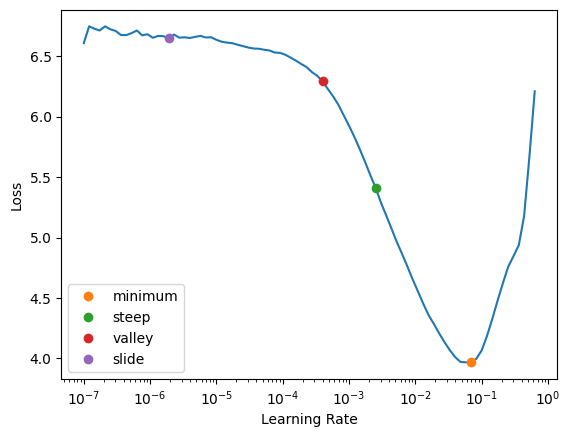

In [12]:
'''
In this cell we are trying to find the optimal learning rate (lr) using the method: lr_find()
lr_find() increases the lr on a subset of training images until the loss diverges or the accuracy drops off
We want to use the .valley value for our base / suggested learning rate in later cells
lr later controls the step size of the gradient descent (GD) whilst training
'''

lr_optimal = learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_sug = lr_optimal.valley
lr_sug_ex = format(lr_sug, '.2e')

print(f'Suggested learning rate: {lr_sug}, and its exponential notation: {lr_sug_ex}')

### Fine Tuning (Training)

In [55]:
'''
The fine_tune method lets us train/fine-tune our model based on a pre-trained model, with new data
fine_tune only works with the last layer of the pre-trained model, the rest of the pre-trained layers are frozen
One could use the fit_one_cycle() method but it is more suited towards training a model from scratch
'''

print(f'Training with: {ep} epochs, with a learning rate of: {lr_sug_ex}\n')

# Start training timing
start_time = datetime.now()

# Train/Fine-tune
learner.fine_tune(ep, lr_sug)

# End training timing
end_time = datetime.now()

print('\nFine-tuning (training) complete.')

Training with: 15 epochs, with a learning rate of: 3.98e-04



epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.129049,0.492299,0.136008,0.863992,00:20


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.114292,0.472985,0.131115,0.868885,00:22
1,0.102203,0.490466,0.135519,0.864481,00:23
2,0.096638,0.493953,0.132094,0.867906,00:23
3,0.097020,0.521439,0.135519,0.864481,00:22
4,0.103242,0.528416,0.137965,0.862035,00:22
5,0.099916,0.544808,0.136986,0.863014,00:22
6,0.078892,0.545625,0.136008,0.863992,00:22
7,0.069389,0.519613,0.131115,0.868885,00:22
8,0.058255,0.527724,0.130626,0.869374,00:22
9,0.053026,0.527048,0.128669,0.871331,00:22


Training time: 363.333446 seconds

Fine-tuning (training) complete.


In [79]:
# Store the total training time as: hr:mm:sec
training_time = end_time - start_time
training_time = str(training_time).split('.')[0]

0:06:03


## Evaluation & Logging

### Evaluate Validation Dataset

In [80]:
'''
The validation method is used to evaluate the performance of the trained model against the validation dataset
We are combining the training metrics, and the used hyperparameters for the model to log as a .json file
We do this to get a better understanding of the trained model, store old training stats, and to better know what to tweak
We are also converting any floating point numbers to percentage values
'''

if log:
    
    # Store the validation metrics
    valid_metrics = learner.validate()
    
    deci_patt = r'^\d+\.\d{3,}$'
    
    '''
    Loop over the validation metrics
    If a metric contains a decimal followd by more than two deciaml points
    Turn the values from floating to % values, and only keep two trailning decimal points
    '''
    
    for i, x in np.ndenumerate(valid_metrics):
        if re.match(deci_patt, str(x)):
            valid_metrics[i] = round((x * 100), 2)
    
    # Create a second array to store the used hyperparameters
    parameters_arr = np.array([arch.__name__, ep, bs, lr_sug_ex, training_time])
    
    # Combine the two arrays into a data frame, and flip the initial col. and rows
    df_trained_stats = pd.DataFrame(np.concatenate([valid_metrics, parameters_arr])).T
    
    # Update the df col. names
    df_trained_stats.columns = ['Loss(%)', 'Error(%)', 'Accuracy(%)', 'Arch', 'EP', 'BS', 'LR', 'Time To Train']
    
    # In this part we are creating or updating a .json file with the df created above
    
    # Current time to add to each input
    curr_time = datetime.now() 
    formatted_time = curr_time.strftime('%d/%m/%Y - %H:%M')

    # Convert the eariler created df to .json, and convert any number represented as strings to floats
    df_trained_stats[['Loss(%)', 'Error(%)', 'Accuracy(%)', 'EP', 'BS']] = df_trained_stats[['Loss(%)', 'Error(%)', 'Accuracy(%)', 'EP', 'BS']].astype(float)
    trained_stats_json = df_trained_stats.to_json(orient='records')
    
    # Create a trained dir. if it doesn't exist
    if not os.path.exists(trained_dir):
        os.mkdir(trained_dir)
        print(f'Created: {trained_dir}')
        
    # If the .json file exists, append new data to it, otherwise create the file and add the data to it
    if os.path.exists(trained_stats): 
        with open(trained_stats, 'r') as f:
            json_obj = json.load(f)
            json_obj[formatted_time] = json.loads(trained_stats_json)
        f.close()
            
        # write the updated .json data back to the file
        with open(trained_stats, 'w') as f:
            json.dump(json_obj, f, indent=2)
        f.close()
            
        print(f'Added new training stats data to: {trained_stats}')
    else:   
        json_obj = {formatted_time: json.loads(trained_stats_json)}
        
        with open(trained_stats, 'w') as f:
            json.dump(json_obj, f, indent=2)
        f.close()
            
        print(f'Created: {trained_stats}')
else:
    print('If you wish to store log, change the log variable in the settings cell.')

0:06:03
Added new training stats data to: /content/trained/trained_model_stats.json


### Evaluate Test Dataset

In [15]:
# Here we use get_preds to test the trained model on a test dataset, contrary to the validate() method get_preds is testing on more 'real-world' data 

test_files = get_image_files(test_dir)

# Create a test dataloader
test_dl = dls.test_dl(test_files, bs=bs)

# Get the predictions on the test dataloader
preds, targs = learner.get_preds(dl=test_dl)

preds.shape

torch.Size([10357, 120])

## Post Training Analysis

In [16]:
# Shows the steps, callbacks, and performance of the model during each training iteration
learner.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [CastToTensor]
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch Loop

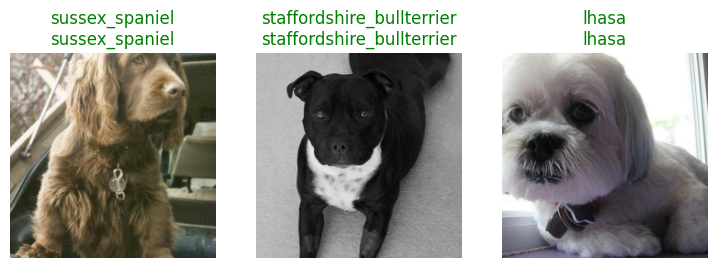

In [17]:
# Show a random batch of images from the trained model
learner.show_results(max_n=3)

In [18]:
# Lets us view, interpret and analyze performance of our trained classification model
interp = ClassificationInterpretation.from_learner(learner)

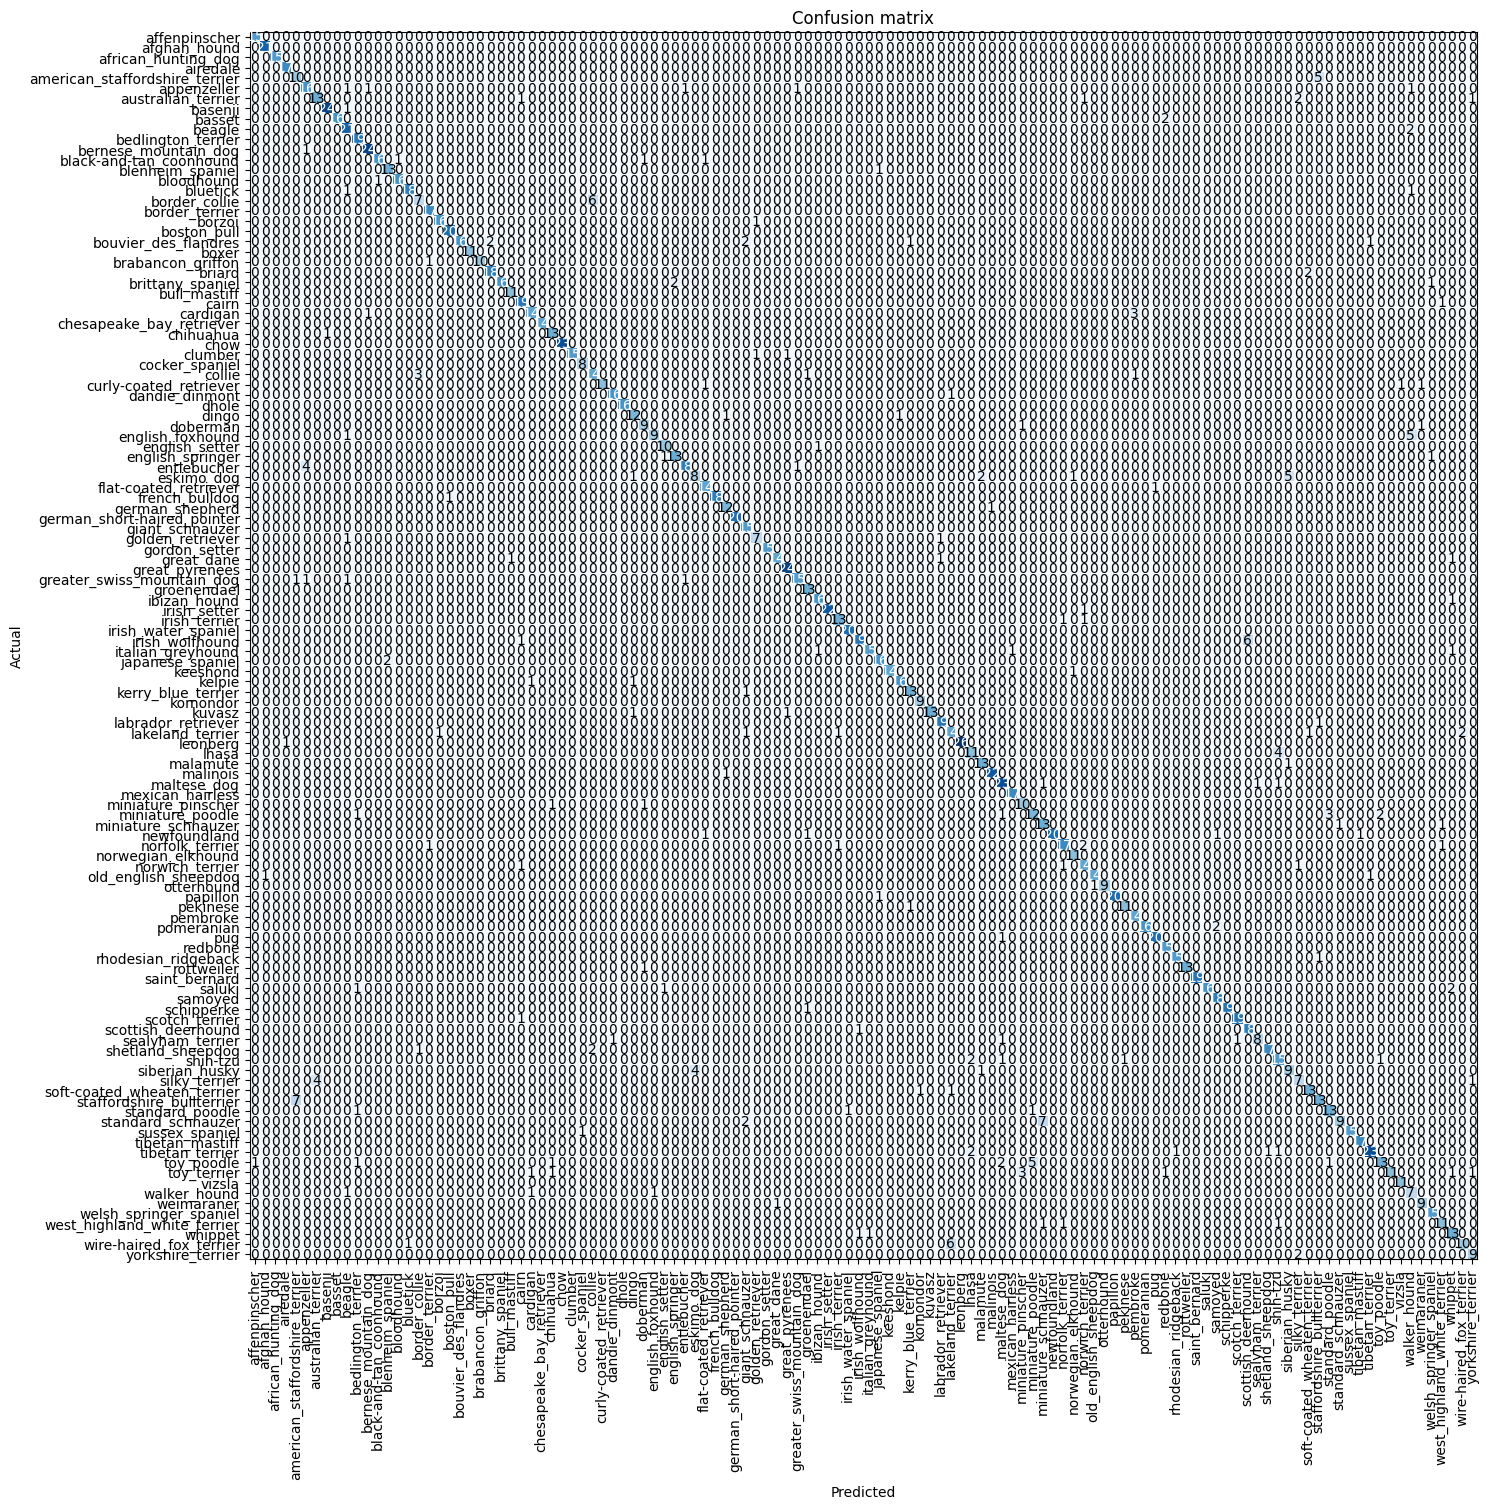

In [19]:
# We plot a matrix that shows us the the distrubution of correctly and incorrectly classified classes
interp.plot_confusion_matrix(figsize=(15, 15))

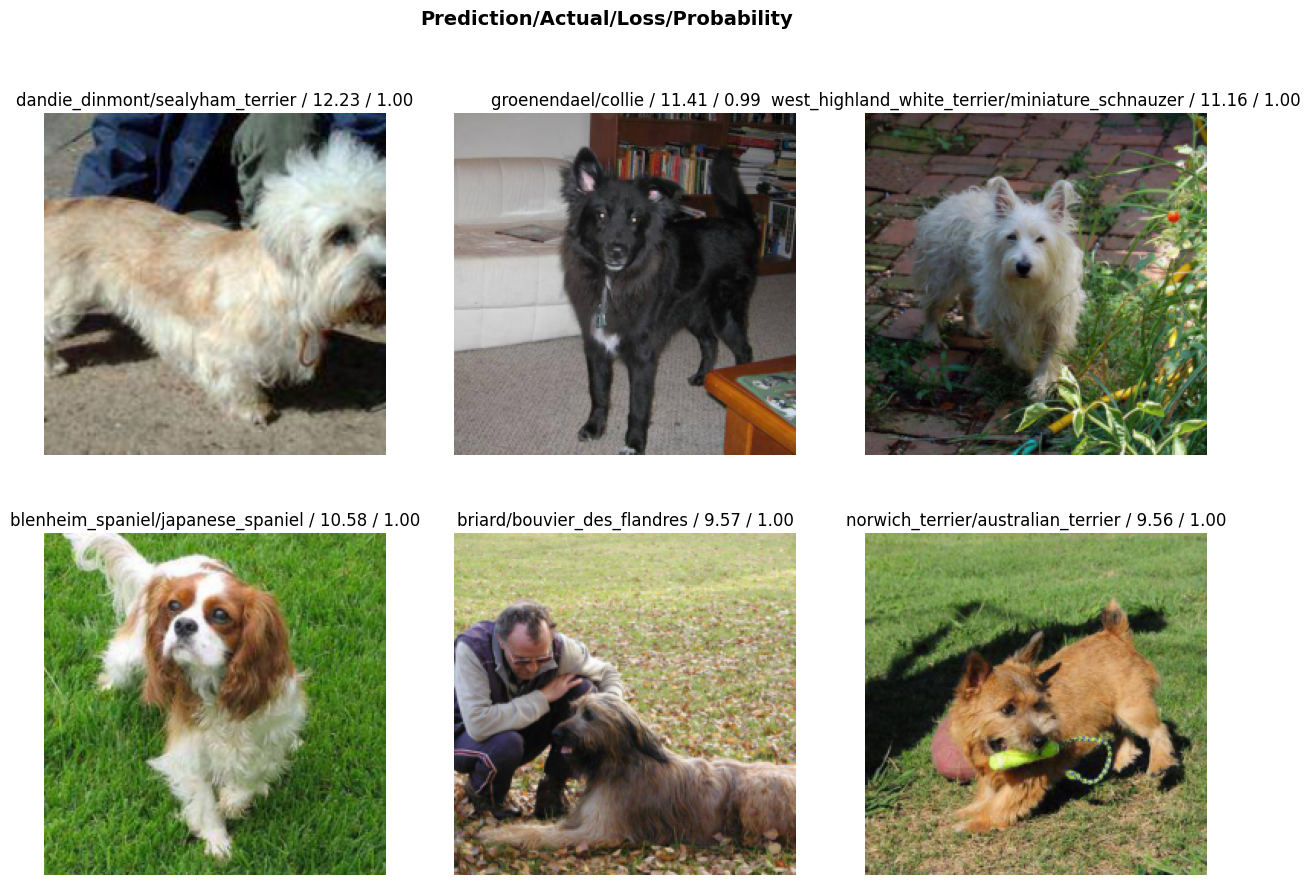

In [20]:
# The 6 worst predicted images i.e. the images with highest losses
interp.plot_top_losses(6, figsize=(15, 10))

In [21]:
# Lets us view the most confused classes classed during training, and how many times they were wrongly predicted
df = pd.DataFrame(data=interp.most_confused(min_val=5))
df.columns = ['Predicted', 'Actual', 'Amount of wrong predictions']
df.head()

,Predicted,Actual,Amount of wrong predictions
0,staffordshire_bullterrier,american_staffordshire_terrier,7
1,standard_schnauzer,miniature_schnauzer,7
2,border_collie,collie,6
3,irish_wolfhound,scottish_deerhound,6
4,wire-haired_fox_terrier,lakeland_terrier,6


## Predictions

In [22]:
# A function to predict the class and confidence, based on a trained model, of an image provided by a URL
def predict_img(img):
    print(img)
    pred_class, pred_idx, probs = learner.predict(img)
    conf = probs[pred_idx] * 100
    print(f'Predicted class: {pred_class.capitalize()}, confidence: {conf:.2f}%')

In [23]:
# Choose an unlabeled, unseen image from the test dataset for prediction
test_img = Path(test_dir).ls()[123]
predict_img(test_img)

/content/stanford-dogs-dataset/test/b1cbd04c30df6d6b46b408e6502db5a4.jpg


Predicted class: Silky_terrier, confidence: 69.58%


In [24]:
# A function that lets us use the BeautifulSoup and HTTP response library to search and download a random dog image from Google
def rand_dog_image_download():
    url = 'https://www.google.com/search?q=dog&tbm=isch'
    res = requests.get(url)
    
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(res.content, 'html.parser')
    
    # Fetch all image tags from the page
    img_tags = soup.find_all('img')
    
    # Filter the image tags to only include ones with a src attribute
    img_tags = [img for img in img_tags if 'src' in img.attrs]
    
    # Choose a random image
    random_img_tag = random.choice(img_tags)
    
    # Get the URL of the random image
    img_url = random_img_tag['src']
    
    # Do a HTTP request to get the image content
    img_res = requests.get(img_url)
    
    # Write the random dog image to a file named rand_dog in the working dir.
    with open('rand_dog.jpg', 'wb') as f:
        f.write(img_res.content)
    f.close()
        
    print(f'Downloaded one random dog image from:\n{img_url}\n')
    
    # Predict
    predict_img(os.path.realpath(f.name))

In [25]:
rand_dog_image_download()

Downloaded one random dog image from:
https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQDDc3exO9UiEZYrHtteuHbk_W8FlpZ8rC-2j_am3azbgDy0D3BvTszlgpFYNg&s

/content/rand_dog.jpg


Predicted class: Rhodesian_ridgeback, confidence: 83.58%


## Export Trained Model

In [26]:
# Exports the trained model as a .pki file in the trained directory
if export_model:
  learner.export(trained_model)
  print(f'Exported trained model file {trained_model}')       
else:
    print('Didn\'t export the trained model, change the export variable in the settings cell if you wish to export.')

Didn't export the trained model, change the export variable in the settings cell if you wish to export.


## Clean-up

In [27]:
# TODO